### Init GD and Data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [74]:
bank_data = pd.read_csv('/content/drive/MyDrive/Data/bank_loan.csv')

### Functions

In [5]:
def show_and_imput_missing_values(df, columns):
    df = df.copy()  # avoid modifying original

    print("=== Missing Value Imputation Report ===")

    # Separate column types
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Handle numeric columns
    for col in numeric_cols:
        missing_count = df[col].isna().sum()
        if missing_count > 0:
            if columns and col in columns:
                df[col + '_missing'] = df[col].isna().astype(int)  # indicator column
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Numeric Column: '{col}' | Missing: {missing_count} | Filled with median ({median_val})")
            print("Unique values: " + str(df[col].unique()[0:10]) + "\n")
    # Handle categorical columns
    for col in categorical_cols:
        missing_count = df[col].isna().sum()
        if missing_count > 0:
            df[col] = df[col].fillna("Unknown")
            print(f"Categorical Column: '{col}' | Missing: {missing_count} | Filled with 'Unknown'")
            print("Unique values: " + str(df[col].unique()) + "\n")


    print("=== Imputation Complete ===\n")
    return df

In [67]:
def plot_feature_vs_target(data, feature_col, target_col):
    data = data.copy()
    groups = data[target_col].unique()

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"Distribution of {feature_col} by {target_col}", fontsize=16)

    # Histogram + KDE
    ax = axes[0,0]
    sns.histplot(data, x=feature_col, hue=target_col, kde=True,
                 element="step", stat="density", common_norm=False, ax=ax, palette="Set1")
    for g in groups:
        vals = data.loc[data[target_col] == g, feature_col].dropna()
        ax.axvline(vals.mean(), linestyle="--", label=f"Mean (target={g}): {vals.mean():.2f}")
        ax.axvline(vals.median(), linestyle=":", label=f"Median (target={g}): {vals.median():.2f}")
    ax.legend()
    ax.set_title("Histogram + KDE with mean/median")

    # Boxplot
    sns.boxplot(data=data, x=target_col, y=feature_col, hue=target_col,
                palette="Set2", showmeans=True, legend=False, ax=axes[0,1])
    axes[0,1].set_title("Boxplot")

    # Violin plot
    sns.violinplot(data=data, x=target_col, y=feature_col, hue=target_col,
                   palette="Set2", inner="box", density_norm="count", legend=False, ax=axes[0,2])
    axes[0,2].set_title("Violin Plot")

    # Barplot
    sns.barplot(data=data, x=target_col, y=feature_col, hue=target_col,
                estimator="mean", errorbar="se", palette="Set2", legend=False, ax=axes[1,0])
    axes[1,0].set_title("Mean ± SE")

    # Q-Q plot
    for g in groups:
        sample = data.loc[data[target_col]==g, feature_col].dropna()
        stats.probplot(sample, dist="norm", plot=axes[1,1])
    axes[1,1].set_title("Q-Q Plot (per group)")

    # Strip plot
    sns.stripplot(data=data, x=target_col, y=feature_col, hue=target_col,
                  palette="Set2", alpha=0.6, jitter=True, legend=False, ax=axes[1,2])
    axes[1,2].set_title("Strip Plot")

    plt.tight_layout()
    plt.show()


In [1]:
def correlation_with_target(data, target_col, alpha=0.05):
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target_col]

    results = []

    for col in numeric_cols:
        group0 = data.loc[data[target_col] == 0, col].dropna()
        group1 = data.loc[data[target_col] == 1, col].dropna()

        if group0.nunique() < 2 or group1.nunique() < 2:
            results.append([col, "N/A", np.nan, np.nan, "Insufficient variance"])
            continue

        # --- Normality tests ---
        def normality_test(sample):
            if len(sample) < 50:
                stat, p = stats.shapiro(sample)
                return p > alpha, "Shapiro"
            else:
                # KS test against normal distribution
                stat, p = stats.kstest((sample - sample.mean())/sample.std(ddof=1), 'norm')
                return p > alpha, "KS"

        norm0, method0 = normality_test(group0)
        norm1, method1 = normality_test(group1)

        # --- Variance test (Levene) ---
        _, p_levene = stats.levene(group0, group1)
        equal_var = p_levene > alpha

        # --- Choose test ---
        if norm0 and norm1:
            if equal_var:
                test_name = "t-test (independent)"
                stat, p_val = stats.ttest_ind(group0, group1, equal_var=True)
            else:
                test_name = "Welch’s t-test"
                stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
        else:
            test_name = "Mann–Whitney U"
            stat, p_val = stats.mannwhitneyu(group0, group1, alternative='two-sided')

        results.append([
            col,
            test_name,
            stat,
            p_val,
            "Significant" if p_val < alpha else "Not significant",
            f"{method0}/{method1}",
            f"{'Equal var' if equal_var else 'Unequal var'}"
        ])

    results_df = pd.DataFrame(results, columns=[
        "Feature", "Test Used", "Statistic", "P-value", "Result", "Normality Tests", "Variance Assumption"
    ])
    return results_df

### Initial Data glimpse

In [75]:
bank_data.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore,LoanApproved
0,2072-08-01,22,63052,631,Employed,Master,2,18271,12,Married,...,5254.333333,0.639338,3.0,1409,0.167771,0.156702,1654.893043,0.397366,51.0,0
1,2068-04-14,42,62117,522,Employed,Associate,20,29281,108,Divorced,...,5176.416667,0.835783,5.0,106328,0.313281,0.294022,774.117592,0.190888,50.0,0
2,2062-04-07,31,32448,544,Employed,Bachelor,5,33395,60,Divorced,...,2704.000000,0.879069,3.0,8626,0.266395,0.286945,1053.817922,0.531368,54.0,0
3,2031-05-29,19,32182,478,Unemployed,Master,0,49105,24,Single,...,2681.833333,0.868833,7.0,96744,0.285105,0.247245,2614.025710,1.125732,53.0,0
4,2024-04-04,45,77191,646,Employed,Master,21,99655,24,Married,...,6432.583333,0.982722,8.0,16312,0.251655,0.256010,5348.835792,0.924642,52.0,0


In [76]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             2050 non-null   object 
 1   Age                         2050 non-null   int64  
 2   AnnualIncome                2050 non-null   int64  
 3   CreditScore                 2050 non-null   int64  
 4   EmploymentStatus            1976 non-null   object 
 5   EducationLevel              2050 non-null   object 
 6   Experience                  2050 non-null   int64  
 7   LoanAmount                  2050 non-null   object 
 8   LoanDuration                2050 non-null   int64  
 9   MaritalStatus               2050 non-null   object 
 10  NumberOfDependents          1963 non-null   float64
 11  HomeOwnershipStatus         1951 non-null   object 
 12  MonthlyDebtPayments         2009 non-null   float64
 13  CreditCardUtilizationRate   2050 

In [77]:
bank_data.describe()

,Age,AnnualIncome,CreditScore,Experience,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore,LoanApproved
count,2050.000000,2.050000e+03,2050.000000,2050.000000,2050.000000,1963.000000,2009.000000,2050.000000,2050.000000,2050.000000,...,2050.000000,2050.000000,1936.000000,2.050000e+03,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000
mean,39.952195,1.558224e+05,572.662927,17.353659,54.058537,1.455425,457.295669,0.294761,2.848780,0.968780,...,4759.490569,0.791977,5.076963,7.737341e+04,0.240882,0.240792,931.094014,0.405455,50.774927,0.239024
std,11.702246,9.780950e+05,63.820500,11.614698,24.404283,1.367463,239.521001,0.162348,1.899773,0.969018,...,3156.760304,0.122874,2.229185,1.340863e+05,0.035993,0.042887,710.769016,0.334684,7.745501,0.426592
min,18.000000,1.500000e+04,384.000000,-4.000000,12.000000,0.000000,85.000000,0.004364,-4.000000,0.000000,...,625.000000,0.276100,0.000000,1.018000e+03,0.130338,0.113310,118.491581,0.034436,30.400000,0.000000
25%,32.000000,3.274900e+04,538.000000,9.000000,36.000000,0.000000,289.000000,0.169033,2.000000,0.000000,...,2586.062500,0.712901,3.000000,9.073750e+03,0.215449,0.210321,511.277136,0.180706,46.000000,0.000000
50%,40.000000,4.926900e+04,575.000000,17.000000,48.000000,1.000000,405.000000,0.278739,3.000000,1.000000,...,3869.750000,0.809762,5.000000,3.569450e+04,0.238110,0.237375,735.522113,0.305972,51.000000,0.000000
75%,48.000000,7.434200e+04,608.000000,25.000000,72.000000,2.000000,568.000000,0.401770,4.000000,2.000000,...,5931.875000,0.887293,6.000000,9.202675e+04,0.264231,0.268571,1118.015055,0.518579,56.000000,0.000000
max,80.000000,1.000000e+07,950.000000,60.000000,120.000000,5.000000,2375.000000,0.835776,10.000000,5.000000,...,21606.500000,0.996563,12.000000,1.645402e+06,0.384555,0.395984,7859.855080,4.143180,76.000000,1.000000


### NaN Values Handeling

In [78]:
bank_data = show_and_imput_missing_values(bank_data, bank_data.columns.tolist())

=== Missing Value Imputation Report ===
Numeric Column: 'NumberOfDependents' | Missing: 87 | Filled with median (1.0)
Unique values: [1. 0. 4. 3. 2. 5.]

Numeric Column: 'MonthlyDebtPayments' | Missing: 41 | Filled with median (405.0)
Unique values: [433. 214. 383. 405. 599. 248. 452. 518. 525. 392.]

Numeric Column: 'JobTenure' | Missing: 114 | Filled with median (5.0)
Unique values: [ 3.  5.  7.  8.  4.  2.  6. 10.  9. 11.]

Categorical Column: 'EmploymentStatus' | Missing: 74 | Filled with 'Unknown'
Unique values: ['Employed' 'Unemployed' 'Self-Employed' 'Unknown']

Categorical Column: 'HomeOwnershipStatus' | Missing: 99 | Filled with 'Unknown'
Unique values: ['Other' 'Rent' 'Mortgage' 'Own' 'Unknown']

=== Imputation Complete ===



### Data Visualization

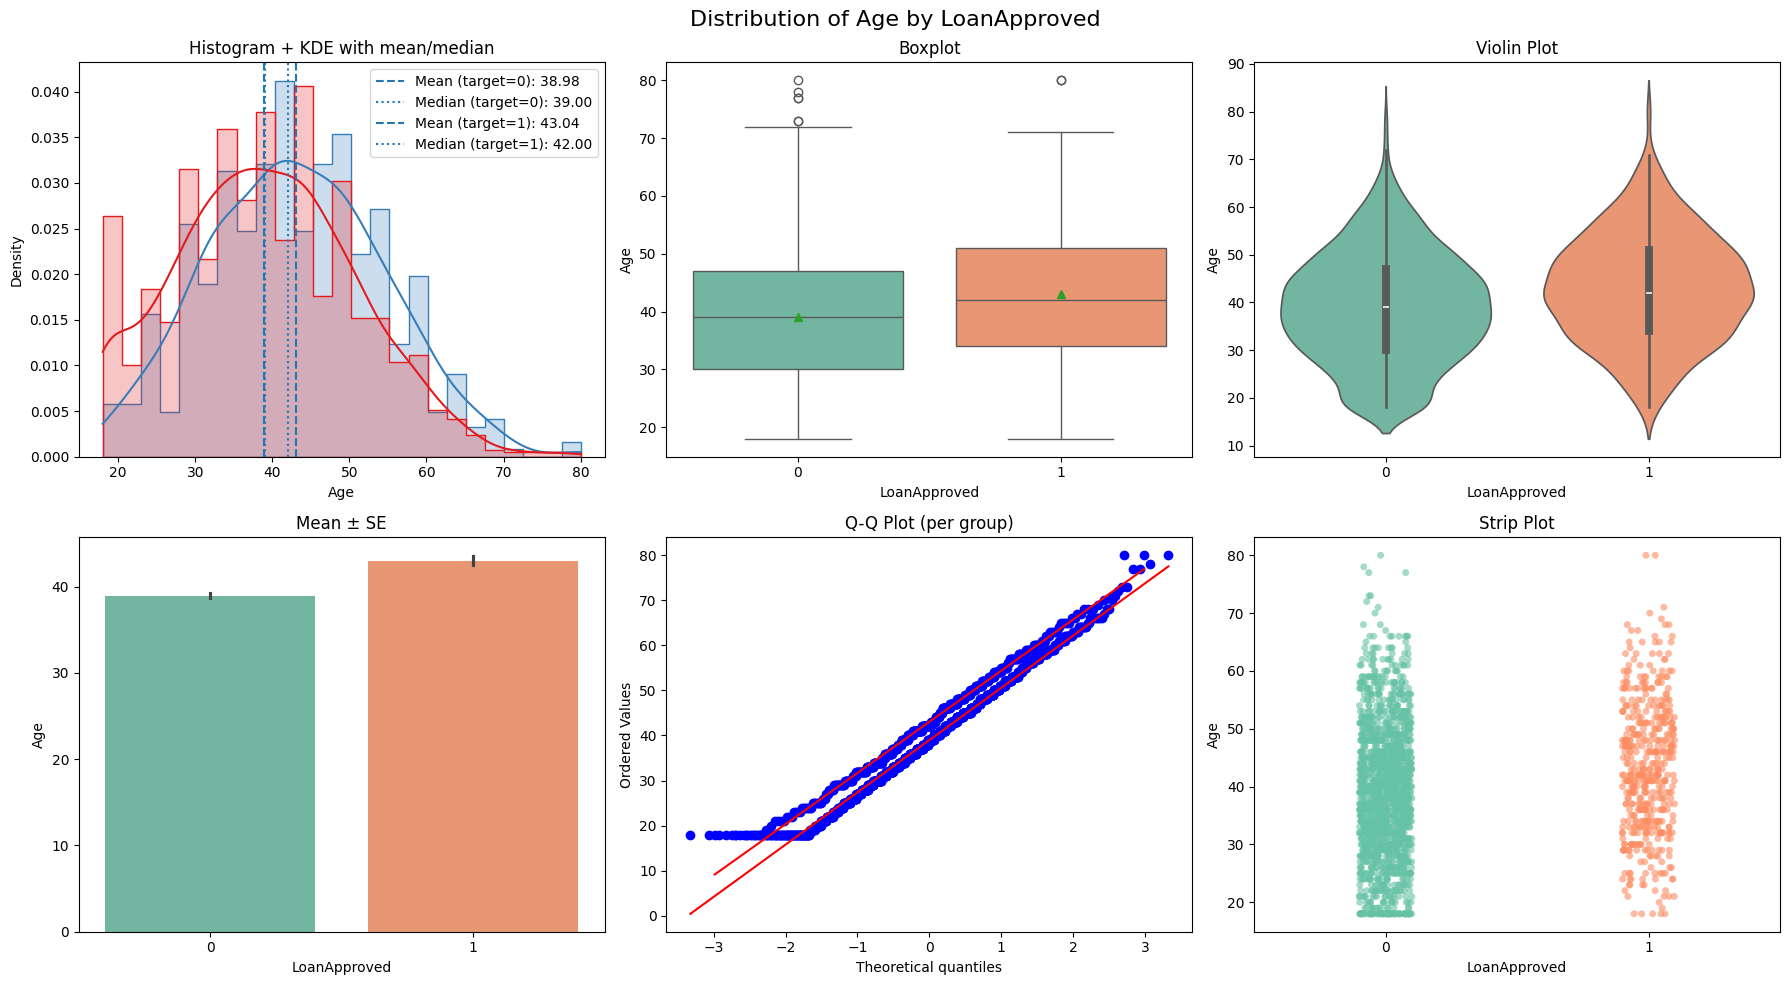

In [79]:
plot_feature_vs_target(bank_data, feature_col="Age", target_col="LoanApproved")

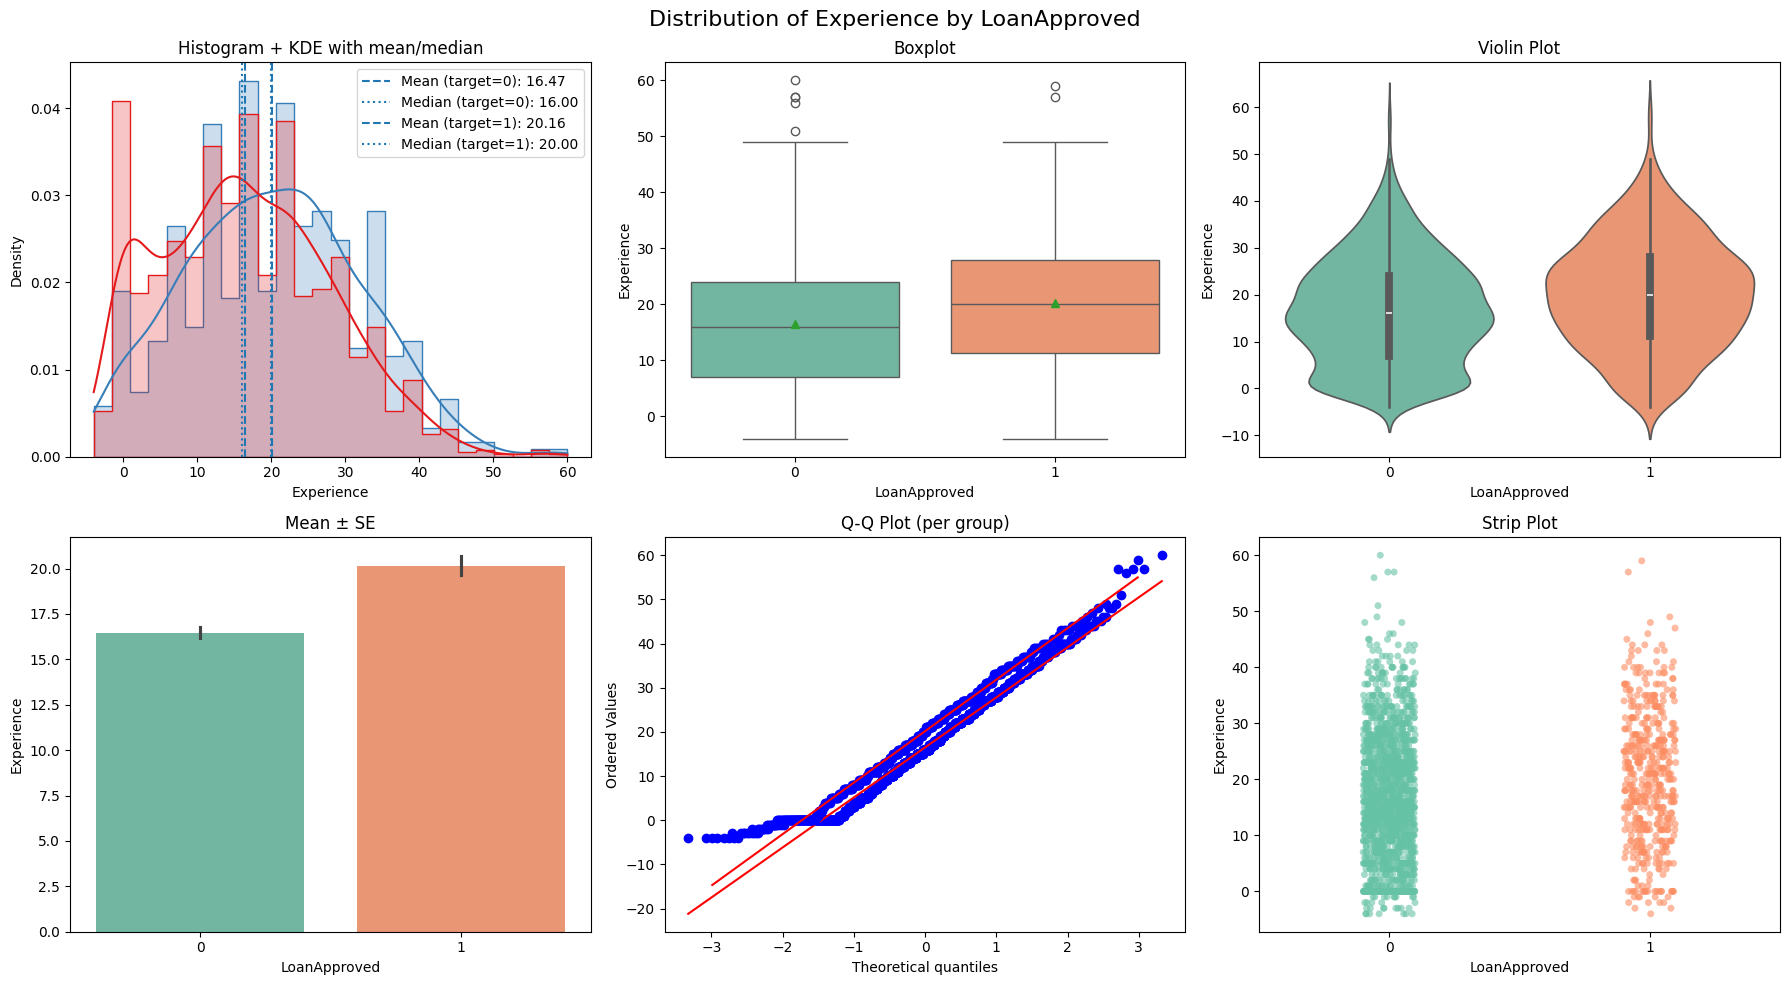

In [80]:
plot_feature_vs_target(bank_data, feature_col="Experience", target_col="LoanApproved")

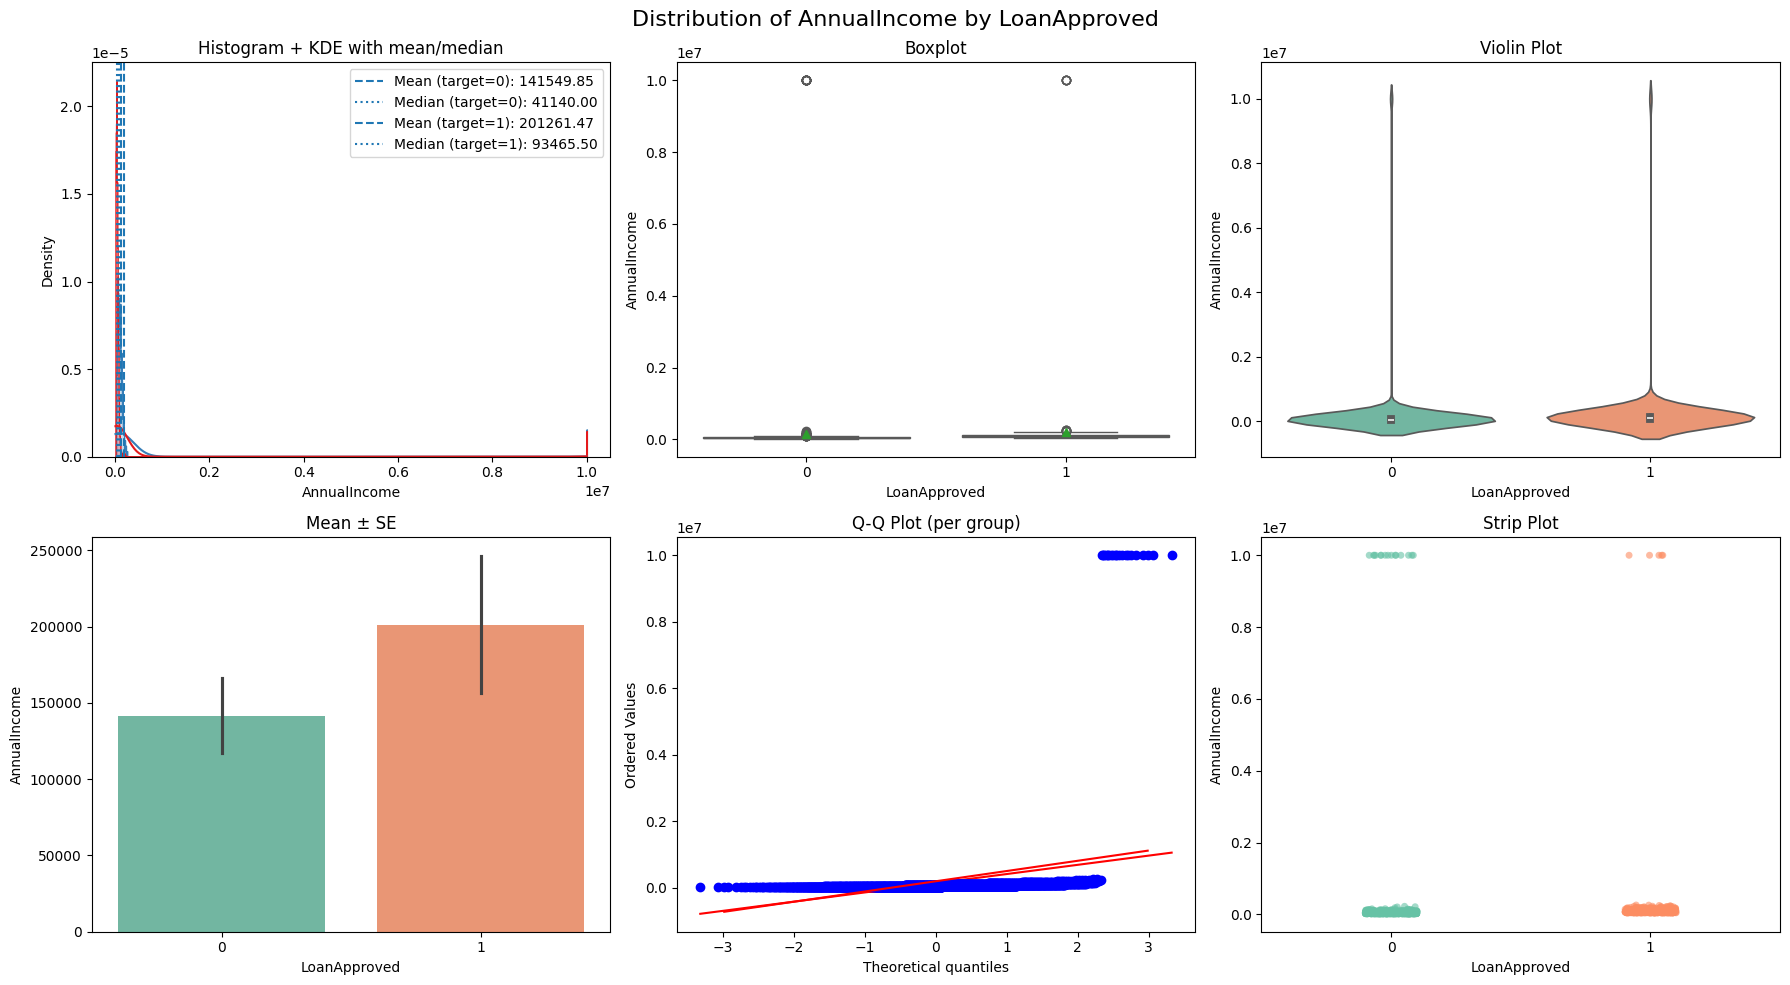

In [81]:
plot_feature_vs_target(bank_data, feature_col="AnnualIncome", target_col="LoanApproved")

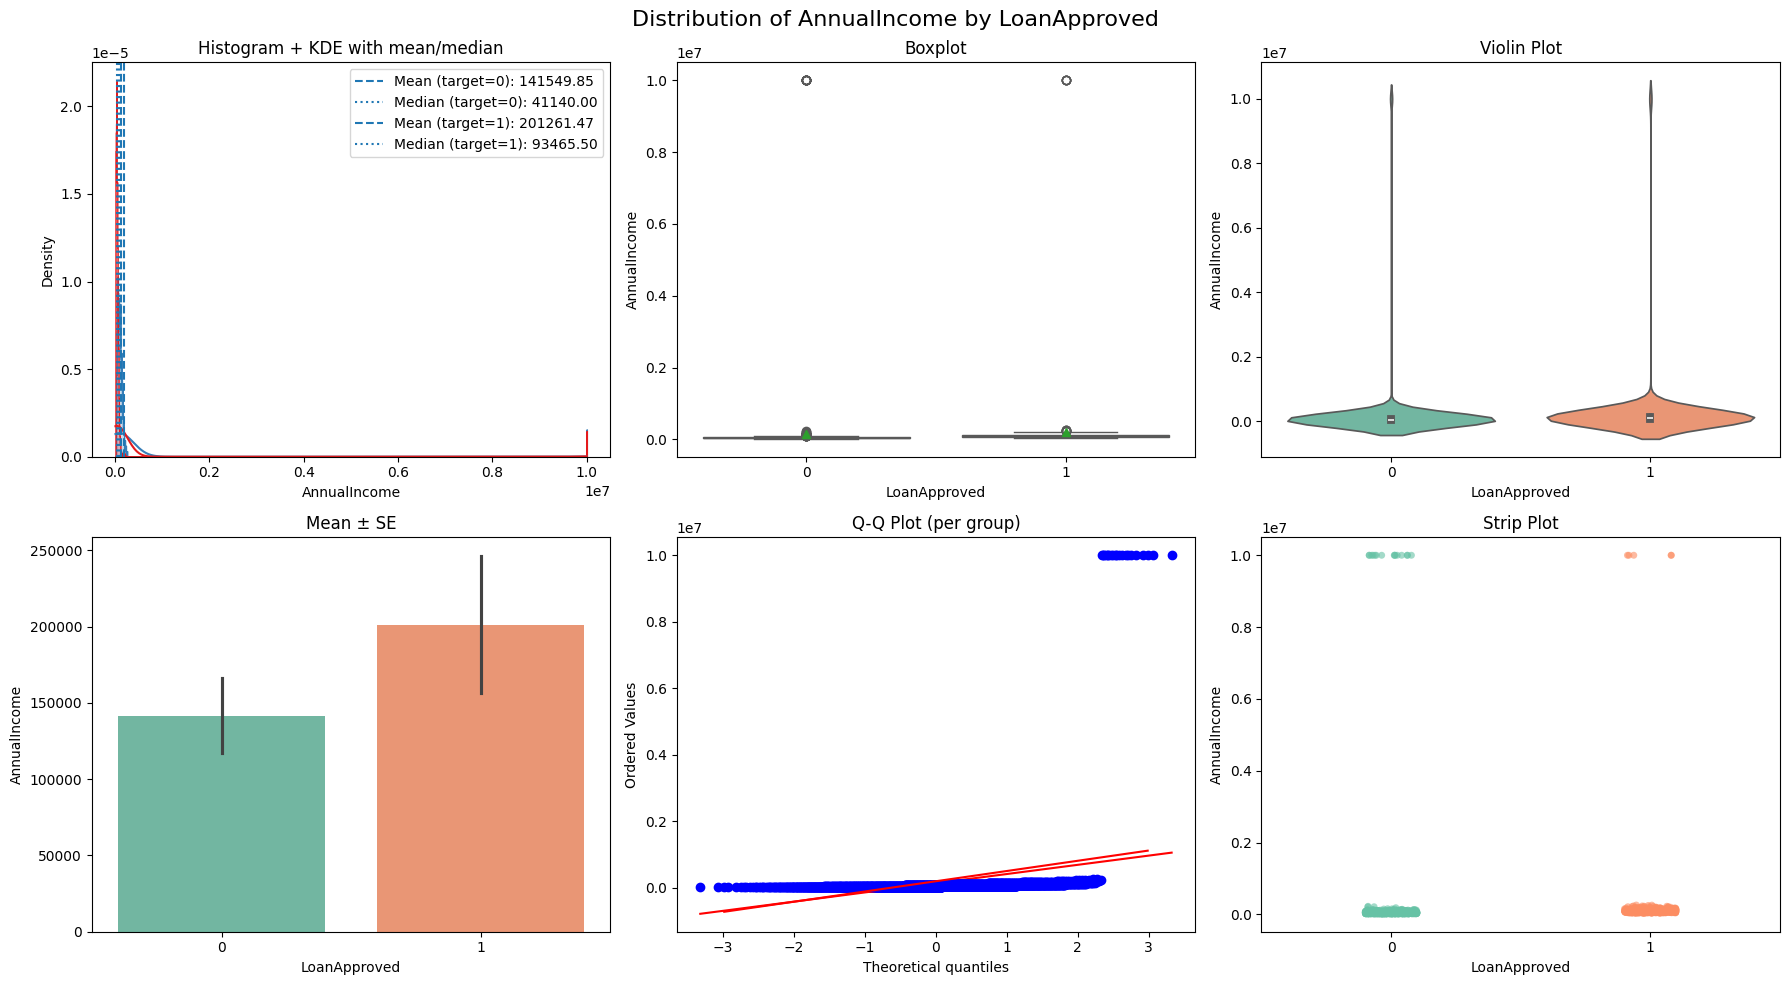

In [82]:
plot_feature_vs_target(bank_data, feature_col="AnnualIncome", target_col="LoanApproved")

### Columns Cleaning

In [83]:
bank_data['AnnualIncome'] = bank_data['AnnualIncome'] / 100000
bank_data['AnnualIncome'].describe()

,AnnualIncome
count,2050.000000
mean,1.558224
std,9.780950
min,0.150000
25%,0.327490
50%,0.492690
75%,0.743420
max,100.000000


### Static Tests

In [35]:
results_df = correlation_with_target(bank_data, "LoanApproved", alpha=0.05)
results_df

,Feature,Test Used,Statistic,P-value,Result,Normality Tests,Variance Assumption
0,Age,Mann–Whitney U,307476.5,6.165603e-11,Significant,KS/KS,Equal var
1,AnnualIncome,Mann–Whitney U,97383.0,4.733222e-137,Significant,KS/KS,Equal var
2,CreditScore,Mann–Whitney U,310618.5,3.786096e-10,Significant,KS/KS,Equal var
3,Experience,Mann–Whitney U,313273.5,1.603398e-09,Significant,KS/KS,Equal var
4,LoanDuration,Mann–Whitney U,428615.5,3.859581e-05,Significant,KS/KS,Unequal var
5,NumberOfDependents,Mann–Whitney U,386440.0,7.019773e-01,Not significant,KS/KS,Equal var
6,MonthlyDebtPayments,Mann–Whitney U,424194.5,2.387878e-04,Significant,KS/KS,Equal var
7,CreditCardUtilizationRate,Mann–Whitney U,389838.0,5.040136e-01,Not significant,KS/KS,Equal var
8,NumberOfOpenCreditLines,Mann–Whitney U,381436.0,9.459093e-01,Not significant,KS/KS,Equal var
9,NumberOfCreditInquiries,Mann–Whitney U,358672.5,2.919874e-02,Significant,KS/KS,Equal var
